 # Configs and Initializations

## Spark

In [86]:
import pyspark
import collections
collections.namedtuple("n", [], module=__name__)


from pyspark.sql import SparkSession

spark = (
    SparkSession
    .builder
    .master("local[{}]".format(70))
    .config("spark.driver.memory", "{}g".format(20))
    .config("spark.driver.maxResultSize", f"{10}g")
    .getOrCreate()
)

SEED = 100001


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/11/11 16:35:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Loading Dataset

## load pickle data

In [2]:
import pickle


PATH = './bios2020.pkl'
with open(PATH, 'rb') as f:
    bios = pickle.load(f)
    
bios[:3]

['Doer, maker, photo-taker. Words: http://fashionist.contently.com BFF.fm Radio DJ: http://bff.fm/shows/mai-charlie',
 'I like to build things (@Foursquare📱, @StockadeFC ⚽️ @StreetFC, Dodgeball 📟) Husband to @Chelsa, dad to 👧🏼❄️ & 👶🏼🚀. I enjoy snowboards, soccer & hot dogs',
 'Product and Design Leader. Formerly @getfandom, @ign, and @yahoo. I build great teams that build great products.']

In [3]:
print(f"size of dataset: {len(bios)}")

size of dataset: 16240577


## convert it to spark dataframe

In [4]:
import pyspark.sql.functions as F

bios_df = spark.createDataFrame([{'text': x} for x in bios])
#bios_df = bios_df.withColumn("id", F.monotonically_increasing_id())

bios_df.show(5)

22/10/17 14:57:00 WARN TaskSetManager: Stage 0 contains a task of very large size (18843 KiB). The maximum recommended task size is 1000 KiB.


22/10/17 14:57:04 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 0 (TID 0): Attempting to kill Python Worker
+--------------------+
|                text|
+--------------------+
|Doer, maker, phot...|
|I like to build t...|
|Product and Desig...|
|Founder at @hello...|
|Compassionate Tec...|
+--------------------+
only showing top 5 rows



## store dataset in parquet format for future

In [9]:
PATH = './bios2020.parquet'
bios_df.write.parquet(PATH, mode='overwrite')

22/10/17 14:41:03 WARN TaskSetManager: Stage 6 contains a task of very large size (18843 KiB). The maximum recommended task size is 1000 KiB.


## loading the parquet dataset

In [2]:
PATH = './bios2020.parquet'
bios_df = spark.read.parquet(PATH)

# Data Preprocessing and Cleaning

## data schema

In [3]:
bios_df.show(5)

+-------------------------+------------+
|                     text|          id|
+-------------------------+------------+
|     taga rt and like ...|549755813888|
|           sookai she her|549755813889|
|     В глубине души вс...|549755813890|
|     ★ 1998 ╱ illusory...|549755813891|
|V→🦊⚔️🍚🔺など 絵描き ...|549755813892|
+-------------------------+------------+
only showing top 5 rows



In [4]:
print(f"total rows: {bios_df.count()}")

total rows: 16240577


## cleaning text

In [31]:
def clean_personal_marker(phrase):
    """ Clean a clause extracted from a description"""
    
    if not phrase:
        return None

    # drop weird special characters
    phrase = phrase.encode('ascii', errors='ignore').decode().strip()
    x_prev = phrase

    while True:
        # remove excess whitespace
        phrase = re.sub(r"\s+", " ", phrase).strip()

        # remove personal markers such as I like X
        phrase = re.sub(r"^i (love|like|enjoy) ", "", phrase)
        # remove personal references such as I am a Y
        phrase = re.sub(r"^(i am|i'm|i'm) (a |an )?", "", phrase)
        # remove personal pronouns
        phrase = re.sub(r"^(i |a[n]?)\b", "", phrase)
        # remove unimportant words at the beginning and end of clause
        phrase = re.sub(r"^(and|the|from|to)\b", "", phrase)
        phrase = re.sub(r" of$", "", phrase)
        
        # removes social media links (snapchat, ig, email and phone address) mentions from bio
        phrase = re.sub(r'(on )?(snapchat|snap|ig|insta|instagram|email|phone): +[A-Za-z0-9_@.-]+', " ", phrase)
        
        # remove special characters
        phrase = re.sub(r'\u200d', "", phrase)

        # remove unimportant marks at the beginning and end of each phrase
        phrase = phrase.strip().strip(".,/!-]+[:)(-?'$%&_").strip()
        
        # remove some markers from the whole sentence
        phrase = re.sub(r"[!\(\)?.\{\}]", " ", phrase).strip()
        
        if phrase == x_prev:
            return phrase

        x_prev = phrase



In [32]:
from tqdm import tqdm
import re
import pyspark.sql.functions as F
import pyspark.sql.types as T
import emoji


def get_emoji_regexp():
    # Sort emoji by length to make sure multi-character emojis are
    # matched first
    emojis = sorted(emoji.EMOJI_DATA, key=len, reverse=True)
    pattern = u'(' + u'|'.join(re.escape(u) for u in emojis) + u')'
    return re.compile(pattern)

emojiexp = get_emoji_regexp()

#@F.udf(returnType=T.ArrayType(T.StringType()))
def generate_personal_identifiers(description):
    """
    Splits up a profile description into a set of clauses. Returns the clauses and
    all emojis in the description (which are being treated as identity markers)
    """

    # lower cases the text
    # remove email addresses
    d = re.sub(r'\w+@\w+\.\w+', '', description.lower()).strip()
    # remove urls
    d = re.sub(r'http\S+', '', d).strip()
    # replace excess space characters
    d = d.replace("&emsp;", "").replace("&nbsp;", "")

    # get all emoji and treat them as split characters
    d = emojiexp.sub("|", string=d)  # .encode("ascii","namereplace").decode()

    # split on sensible split characters
    # | and
    spl = [x for x in re.split(
        r"[\(\)|•*;~°,\n\t]|[!…]+|[-–\/.]+ | [&+:]+ | [+] |([\/])(?=[A-Za-z ])|([.!-]{2,})| and |([#@][A-Za-z0-9_]+)",
        d.lower()) if (
                   x and x.strip() != "" and not x.strip() in "|•&*#;~°.!…-/–")]

    # clean all clauses
    spl = [clean_personal_marker(x) for x in spl]
    
    # remove weird things and things that become empty
    spl = [x for x in spl if x.strip() != "" and x.encode() != b'\xef\xb8\x8f']
    
    return spl
        


In [7]:
bios_df = bios_df.withColumn('pi', generate_personal_identifiers(F.col('text')))

bios_df.persist()
bios_df.show(5)

22/10/17 14:57:19 WARN TaskSetManager: Stage 1 contains a task of very large size (18843 KiB). The maximum recommended task size is 1000 KiB.


ERROR:root:KeyboardInterrupt while sending command.                 (0 + 1) / 1]
Traceback (most recent call last):
  File "/home/csgrad/smadani/venvs/general/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/csgrad/smadani/venvs/general/lib/python3.8/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt

KeyboardInterrupt



In [11]:
#remove bios with empty personal identifiers detected
bios_df = bios_df.filter(F.size(F.col('pi')) > 0)
bios_df.select("id", F.col('pi').alias("pis")).write.parquet("pis.parquet")

# EDA

## load data

In [3]:
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

pis_df = spark.read.parquet('pis.parquet')
pis_df.persist()

pis_df.show(5)
n_distinct_bios = pis_df.count()

+-----------+--------------------+
|         id|                 pis|
+-----------+--------------------+
|42949672960|[harold edward st...|
|42949672961|[tony, underrated...|
|42949672962|[no sides, just g...|
|42949672963|[fan account, o, ...|
|42949672964|[lder del club ni...|
+-----------+--------------------+
only showing top 5 rows



In [45]:
n_distinct_bios

15033198

## distribution of number of pis each user have

Text(0.5, 1.0, 'distribution of number of PIs in a bio')

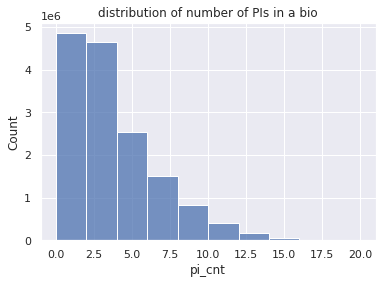

In [36]:

pi_cnt_df = (
    pis_df
    .withColumn('pi_cnt', F.size(F.col('pis')))
    .select('id', 'pi_cnt')
    .toPandas()
)

sns.histplot(pi_cnt_df['pi_cnt'], log_scale=False, bins=[0,2,4,6,8,10,12,14,16,18,20])
plt.title("distribution of number of PIs in a bio")


In [37]:
np.mean(pi_cnt_df['pi_cnt']), np.median(pi_cnt_df['pi_cnt'])

(3.4150380378147083, 2.0)

## extract qunatifying stats

In [31]:
import pyspark.sql.functions as F


pi_df = pis_df.select("id", F.explode("pis").alias("pi"))

# remove single character PIs
pi_df = pi_df.filter(F.length(F.col('pi'))>1)

pi_df.persist()
pi_df.show(5)

# counting distinct bios
n_distinct_pis = pi_df.select("pi").distinct().count()

# calculating frequency of each pi
pi_cnt_pdf = pi_df.groupBy("pi").agg(F.count(F.lit(1)).alias('cnt')).toPandas()
counts = pi_cnt_pdf['cnt']


+-----------+--------------------+
|         id|                  pi|
+-----------+--------------------+
|42949672960|harold edward sty...|
|42949672961|                tony|
|42949672961|underrated contro...|
|42949672961|             manager|
|42949672961|               dm me|
+-----------+--------------------+
only showing top 5 rows



In [46]:
n_distinct_pis

19784548

## hashtag pis

In [38]:
import pyspark.sql.types as T

hashtags_df = pi_df.filter(pi_df.pi.rlike('#[a-zA-Z0-9(_)]+')).withColumnRenamed('pi', 'hashtag')
hashtags_df.show(10)

+-----------+---------------+
|         id|        hashtag|
+-----------+---------------+
|42949672964|          #gor7|
|42949672964|         #goest|
|42949672964|         #t1win|
|42949672964|        #flywin|
|42949672975|     #gregghead|
|42949672977|    #calicarter|
|42949672977|  #abelladanger|
|42949672977|     #meganrain|
|42949672977|#adrianachechik|
|42949672987|    #fitstyczen|
+-----------+---------------+
only showing top 10 rows



In [39]:
# extract distinct hashtags
n_distinct_hashtags = hashtags_df.select('hashtag').distinct().count()
n_distinct_hashtags

847260

In [40]:
# extract ratio of users that use hashtags in their bios

users_with_hashtags = hashtags_df.select("id").distinct()
print(users_with_hashtags.count())


1979278


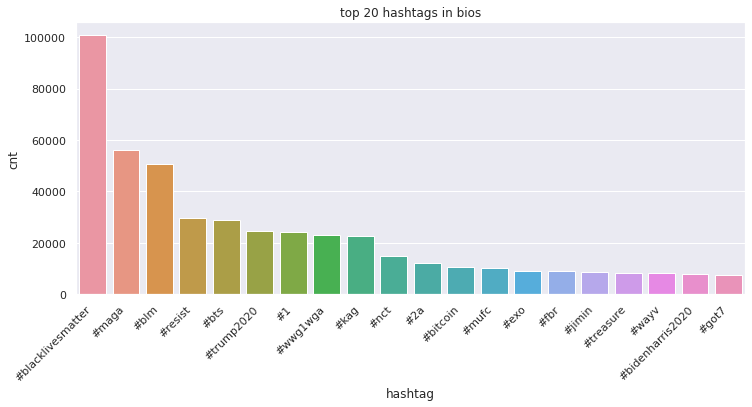

In [43]:
import seaborn as sns
sns.set_theme()

import matplotlib.pyplot as plt

def plot_top_k(df, col, title, k=10):
    grouped_df = (
        df
        .groupBy(col)
        .agg(F.count(F.lit(1)).alias('cnt'))
        .orderBy(F.col('cnt').desc())
        .limit(k)
    ).toPandas()
    
    plt.figure(figsize=(12, 5))
    sns.barplot(data=grouped_df, x=col, y='cnt')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.show()

plot_top_k(hashtags_df, 'hashtag', title='top 20 hashtags in bios', k=20)

## PI frequency stats

In [5]:
import numpy as np
import seaborn as sns


# extract mean and median of pi 
mean_pi_cnt, median_pi_cnt = np.mean(list(counts)), np.median(list(counts))
mean_pi_cnt, median_pi_cnt

(2.5948929796894142, 1.0)

Text(0.5, 1.0, 'distribution of frequency of each PI')

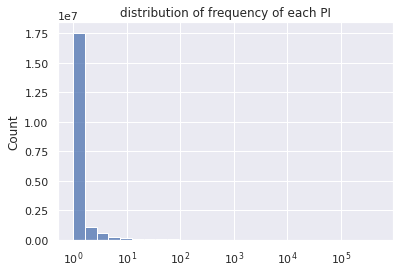

In [47]:
sns.histplot(list(counts), log_scale=True)
plt.title("distribution of frequency of each PI")

## keeping meaningful PIs

based on the above count distribution of PIs, since most of the PIs are unique and never occured, they are not 
informative for this task, so I try to clean data and only keep most informative PIs by removing PIs that repeat
less than 10 times in the dataset

In [50]:
pi_cnt_df = (
    pi_df
    .groupBy("pi").agg(F.count(F.lit(1)).alias('cnt'))
    .filter(F.col('cnt') > 10)
)

pi_cnt_pdf = pi_cnt_df.toPandas()
counts = list(pi_cnt_pdf['cnt'])

In [51]:
filtered_pi_df = pi_df.join(pi_cnt_df, how='right', on='pi')
filtered_pi_df.show(5)

+-----+-----------+-----+
|   pi|         id|  cnt|
+-----+-----------+-----+
|anime|42949673480|31405|
|anime|42949674506|31405|
|anime|42949675356|31405|
|anime|42949676196|31405|
|anime|42949676306|31405|
+-----+-----------+-----+
only showing top 5 rows



In [53]:
print(f'distinct users after filtering: {filtered_pi_df.select("id").distinct().count()}')
print(f'distinct pis after filtering: {filtered_pi_df.select("pi").distinct().count()}')

ht_cnt = filtered_pi_df.filter(pi_df.pi.rlike('#[a-zA-Z0-9(_)]+'))\
.withColumnRenamed('pi', 'hashtag').select("hashtag").distinct().count()

print(f'distinct hashtags after filtering: {ht_cnt}')

distinct users after filtering: 10242965


distinct pis after filtering: 266679


distinct hashtags after filtering: 32412


In [54]:
# extract mean and median of pi 
mean_pi_cnt, median_pi_cnt = np.mean(counts), np.median(counts)
mean_pi_cnt, median_pi_cnt

(100.10152655439686, 22.0)

<AxesSubplot:ylabel='Count'>

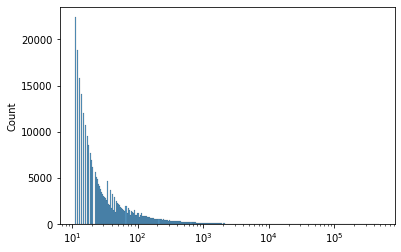

In [9]:
sns.histplot(list(counts), log_scale=True)

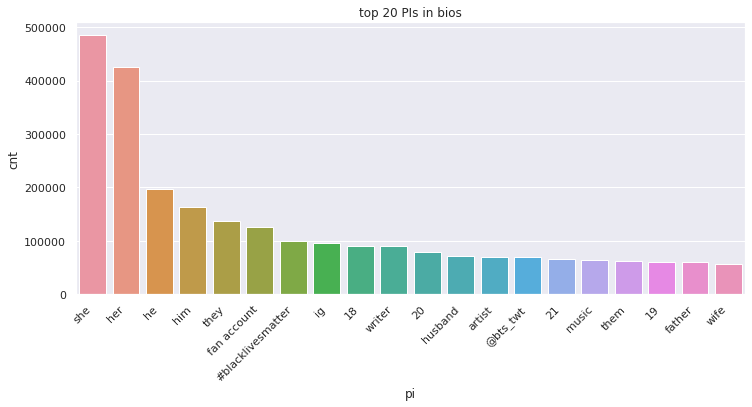

In [44]:
plot_top_k(pi_df, col='pi', k=20, title='top 20 PIs in bios')

## pie chart of democrats and republicans based on keywords

In [64]:

dem_kw = [
    'biden supporter', 'bidenharris', 'bidenharris2020', 'biden2020', 
    'democrat', 
]

repub_kw = [
    'republican', 'trump supporter', 'trump2020', 'maga',
     'conservative'
]

repubs = pi_df.filter(pi_df.pi.rlike('|'.join(repub_kw))).select('id').distinct()
dems = pi_df.filter(pi_df.pi.rlike('|'.join(dem_kw))).select('id').distinct()

others = (
    pi_df
    .select('id').distinct()
    .join(repubs, how='left_anti')
    .join(dems, how='left_anti')
    .select('id')
)

data = [repubs.count(), dems.count()]
labels = ['republican', 'democrat']



In [63]:
repubs.count(), dems.count(), pi_df.select('id').distinct().count()

(174788, 47702, 14908979)

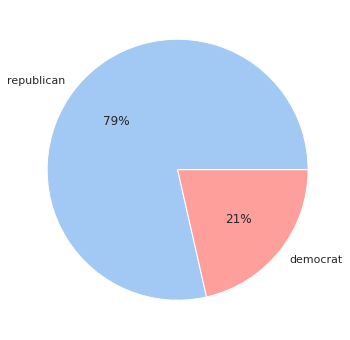

In [66]:
colors = sns.color_palette('pastel')[0:5]
colors = [colors[0], colors[3],]

plt.figure(figsize=(6,6))
plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

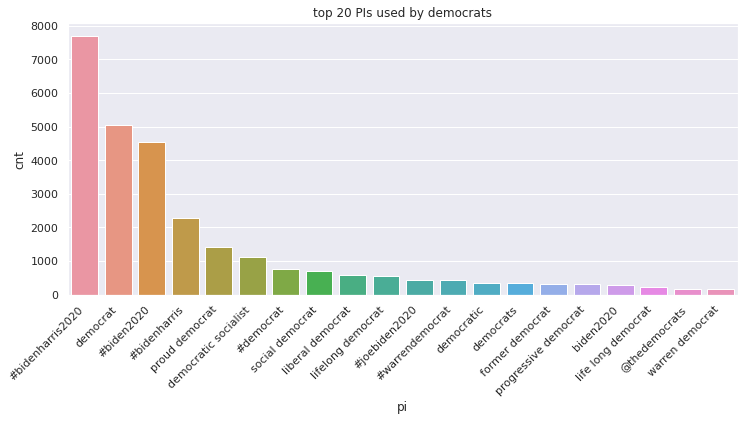

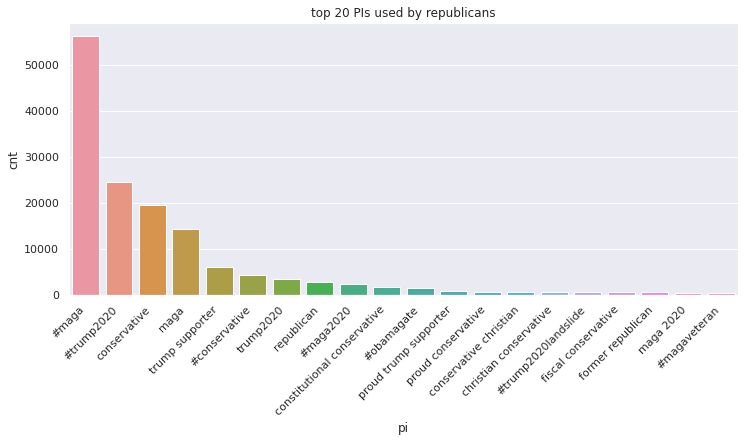

In [67]:
repubs = pi_df.filter(pi_df.pi.rlike('|'.join(repub_kw)))
dems = pi_df.filter(pi_df.pi.rlike('|'.join(dem_kw)))

plot_top_k(dems, col='pi', k=20, title='top 20 PIs used by democrats')
plot_top_k(repubs, col='pi', k=20, title='top 20 PIs used by republicans')

# Combining with demographic information

## loading demographic information

In [87]:
import pandas as pd
from pyspark.sql.types import *
import pyspark.sql.functions as F

schema = StructType([ 
    StructField("state", StringType(), True),
    StructField("gender", StringType(), True), 
    StructField("age", IntegerType(),True), 
    StructField("race", StringType(), True), 
    StructField("partisan_score", FloatType(), True), 
    StructField("followers_count", IntegerType(), True),
    StructField("description", StringType(), True), 
    StructField("verified", StringType(), True), 
])

df = spark.read.parquet('data/demographic.parquet/', schema=schema)
df = df.filter(F.col('partisan_score').isNotNull())

df.count(), df.show()


+-----+-------+---+---------+--------------+---------------+--------------------+--------+
|state| gender|age|     race|partisan_score|followers_count|         description|verified|
+-----+-------+---+---------+--------------+---------------+--------------------+--------+
|   NY|   Male| 39|Caucasian|            95|          24210|Human potential b...|   FALSE|
|   CA|   Male| 51|Caucasian|          50.6|          11952|Human Augmentatio...|   FALSE|
|   CA|   Male| 33|Caucasian|          98.8|           2503|Food, design, tec...|   FALSE|
|   CA|   Male| 44|Caucasian|          85.8|          26525|Here to talk prod...|    TRUE|
|   NV|   Male| 48|Caucasian|          52.8|            408|Art Director @Dia...|   FALSE|
|   CA| Female| 45|Caucasian|          98.9|             62|rebuilding from 2...|   FALSE|
|   CA|   Male| 52|Caucasian|            53|           2683|bassist, designer...|   FALSE|
|   NY| Female| 40|Caucasian|          98.6|         238591|sociotechnical re...|    TRUE|

(1018000, None)

## EDA of demographics

In [88]:
df.filter(F.col('description').contains('blacklivesmatter')).count()

789

In [89]:
df.filter(F.col('description').contains('blacklivesmatter')).filter(F.col('partisan_score')<35).count(),\
df.filter(F.col('description').contains('blacklivesmatter')).filter(F.col('partisan_score')>=35).count()

(133, 656)

### distribution of demographics

In [90]:
import seaborn as sns

dems_df = (
    df
    .filter(F.col('followers_count').isNotNull())
    .filter(F.col('age').isNotNull())
    .toPandas())[["age", "partisan_score", "followers_count"]]

dems_df

,age,partisan_score,followers_count
0,39,95,24210
1,51,50.6,11952
2,33,98.8,2503
3,44,85.8,26525
4,48,52.8,408
...,...,...,...
991792,23,91.9,47
991793,24,96.2,128
991794,24,68.3,15
991795,19,89.1,96


In [91]:
dems_df['partisan_score'] = dems_df['partisan_score'].astype('float')

<AxesSubplot:xlabel='partisan_score'>

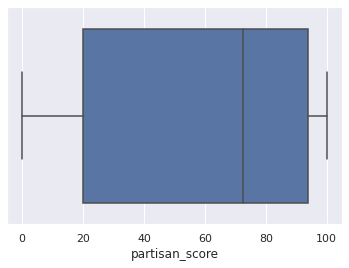

In [92]:
sns.boxplot(x=dems_df['partisan_score'])

<AxesSubplot:xlabel='partisan_score', ylabel='Count'>

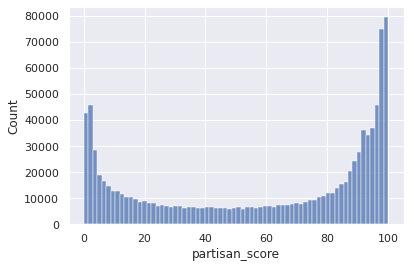

In [93]:
sns.histplot(dems_df['partisan_score'])

## keeping all partisan_socres and profile bios

In [117]:
data_clc = df.collect()

features = [x.description for x in data_clc]
target = [float(x.partisan_score) for x in data_clc]

# making a classification problem
target = [1 if t >= 35.0 else 0 for t in target]

print(min(target), max(target))

0 1


### save and load dataset

In [1]:
import pickle

# save

# dataset = list(zip(features, target))
# with open('bio_dem_dataset.pkl', 'wb') as f:
#     pickle.dump(dataset, f)
    
    
# load

with open('bio_dem_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

### creating train, test and validation sets

In [4]:
from sklearn.model_selection import train_test_split

SEED = 100001

train_ds, test_ds = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=SEED)
train_ds, valid_ds = train_test_split(train_ds, test_size=0.1, random_state=SEED)

print(f"train set size: {len(train_ds)}")
print(f"test set size: {len(test_ds)}")
print(f"validation set size: {len(valid_ds)}")

train set size: 732960
test set size: 203600
validation set size: 81440


## getting embedding vectors from bios

### tf-idf vectors

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
import umap

vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    min_df=500
    
)

train_features = [x[0] for x in train_ds]
train_tfidf = vectorizer.fit_transform(train_features)

test_features = [x[0] for x in test_ds]
valid_features = [x[0] for x in valid_ds]

test_tfidf = vectorizer.transform(test_features)
valid_tfidf = vectorizer.transform(valid_features)

print(train_tfidf.shape)


(732960, 1800)


In [5]:
test_y = [x[1] for x in test_ds]
valid_y = [x[1] for x in valid_ds]
train_y = [x[1] for x in train_ds]

## helper functions

In [5]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def calculate_metrics(preds, labels):
    prec, recall, f1, _ = precision_recall_fscore_support(labels, preds)
    acc = accuracy_score(labels, preds)
    return prec[0], recall[0], f1[0], acc


## Logistic Regression

### train model and find best parameters

In [7]:
%%time

from sklearn.linear_model import LogisticRegression




train_acc = []
train_f1 = [] 
train_prec = []
train_recall = []

valid_acc = []
valid_f1 = [] 
valid_prec = []
valid_recall = []

for max_iter in [5, 10, 25, 50, 100, 150, 200]:
    clf = LogisticRegression(
        penalty='l2',
        max_iter=max_iter,
        verbose=0,
        n_jobs=10
    ).fit(train_tfidf, train_y)
    
    preds = clf.predict(train_tfidf)
    tp, tr, tf, ta = calculate_metrics(preds, train_y)
    train_acc.append(ta)
    train_prec.append(tp)
    train_recall.append(tr)
    train_f1.append(tf)
    
    preds = clf.predict(valid_tfidf)
    tp, tr, tf, ta = calculate_metrics(preds, valid_y)
    valid_acc.append(ta)
    valid_prec.append(tp)
    valid_recall.append(tr)
    valid_f1.append(tf)
    
    


CPU times: user 6.32 s, sys: 333 ms, total: 6.66 s
Wall time: 53.1 s


### visualize metrics

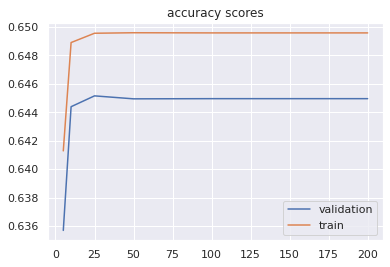

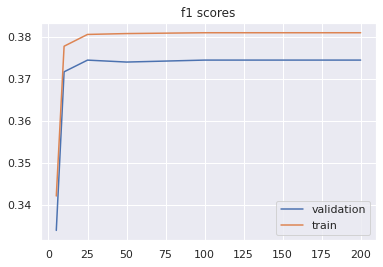

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

iters = [5, 10, 25, 50, 100, 150, 200]

sns.lineplot(x=iters, y=valid_acc)
sns.lineplot(x=iters, y=train_acc)
plt.legend(['validation', 'train'])
plt.title("accuracy scores")
plt.show()

sns.lineplot(x=iters, y=valid_f1)
sns.lineplot(x=iters, y=train_f1)
plt.legend(['validation', 'train'])
plt.title("f1 scores")
plt.show()


#### pick best model and report test metrics

In [9]:
clf = LogisticRegression(
    penalty='l2',
    max_iter=25,
    verbose=1,
    n_jobs=10
).fit(train_tfidf, train_y)

preds = clf.predict(test_tfidf)
tp, tr, tf, ta = calculate_metrics(preds, test_y)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:    4.9s finished


In [10]:
import tabulate

print(tabulate.tabulate([['test_precision', tp], ['test_recall', tr], ['test_f1', tf], ['test_accuracy', ta]], tablefmt='grid'))

+----------------+----------+
| test_precision | 0.602238 |
+----------------+----------+
| test_recall    | 0.272909 |
+----------------+----------+
| test_f1        | 0.375608 |
+----------------+----------+
| test_accuracy  | 0.647559 |
+----------------+----------+


## SVM

### train model and find best parameters

In [43]:
%%time

from sklearn.svm import SVC


train_acc = []
train_f1 = [] 
train_prec = []
train_recall = []

valid_acc = []
valid_f1 = [] 
valid_prec = []
valid_recall = []

for max_iter in [5, 10, 25, 50, 100, 150, 200]:
    clf = SVC(
        max_iter=max_iter,
        verbose=0,
    ).fit(train_tfidf, train_y)
    
    preds = clf.predict(train_tfidf)
    tp, tr, tf, ta = calculate_metrics(preds, train_y)
    train_acc.append(ta)
    train_prec.append(tp)
    train_recall.append(tr)
    train_f1.append(tf)
    
    preds = clf.predict(valid_tfidf)
    tp, tr, tf, ta = calculate_metrics(preds, valid_y)
    valid_acc.append(ta)
    valid_prec.append(tp)
    valid_recall.append(tr)
    valid_f1.append(tf)
    
    


/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=25).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler

CPU times: user 1min 19s, sys: 1.17 s, total: 1min 20s
Wall time: 1min 20s


### visualize metrics

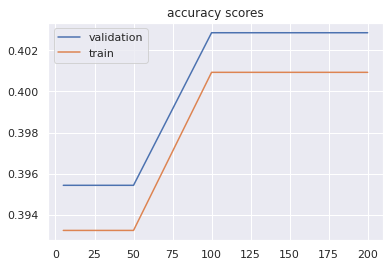

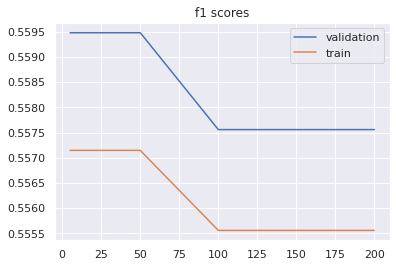

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

iters = [5, 10, 25, 50, 100, 150, 200]

sns.lineplot(x=iters, y=valid_acc)
sns.lineplot(x=iters, y=train_acc)
plt.legend(['validation', 'train'])
plt.title("accuracy scores")
plt.show()

sns.lineplot(x=iters, y=valid_f1)
sns.lineplot(x=iters, y=train_f1)
plt.legend(['validation', 'train'])
plt.title("f1 scores")
plt.show()


#### pick best model and report test metrics

In [ ]:
clf = SVC(
    max_iter=50,
    verbose=1,
).fit(train_tfidf, train_y)

preds = clf.predict(test_tfidf)
tp_svm, tr_svm, tf_svm, ta_svm = calculate_metrics(preds, test_y)

[LibSVM]....

In [46]:
import tabulate

print(tabulate.tabulate([['test_precision', tp_svm], ['test_recall', tr_svm], ['test_f1', tf_svm], ['test_accuracy', ta_svm]], tablefmt='grid'))

+----------------+----------+
| test_precision | 0.388712 |
+----------------+----------+
| test_recall    | 0.981122 |
+----------------+----------+
| test_f1        | 0.556818 |
+----------------+----------+
| test_accuracy  | 0.39335  |
+----------------+----------+


## Random Forest along with dimension reduction

### using umap for dimension reduction

In [ ]:
%%time

import numpy as np
import umap

reducer = umap.UMAP(
    n_components=3,
    n_jobs=20,
#     low_memory=True
)

sample_indices = np.random.randint(0, train_tfidf.shape[0], size=train_tfidf.shape[0]//10)
sample = train_tfidf[sample_indices]
print(f"sample size: {sample.shape[0]}")

reducer = reducer.fit(sample)
print("finished fitting umap")

train_umap = reducer.transform(train_tfidf)
valid_umap = reducer.transform(valid_tfidf)
test_umap = reducer.transform(test_tfidf)


sample size: 73296
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
finished fitting umap


/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### saving intermediate data

In [28]:
with open('train_umap.pkl', 'wb') as f:
    pickle.dump(train_umap, f)
    
with open('valid_umap.pkl', 'wb') as f:
    pickle.dump(valid_umap, f)
    
with open('test_umap.pkl', 'wb') as f:
    pickle.dump(test_umap, f)
    

### loading intermediate data

In [75]:
with open('train_umap.pkl', 'rb') as f:
    train_umap = pickle.load(f)
    
with open('valid_umap.pkl', 'rb') as f:
    valid_umap = pickle.load(f)
    
with open('test_umap.pkl', 'rb') as f:
    test_umap = pickle.load(f)


### grid-search for best parameters

In [76]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


f1s = []
best_f1 = 0
best_clf = None

for ne in [100, 200]:
    for md in [5, 7, 9]:
        clf = RandomForestClassifier(
            n_estimators=ne,
            max_depth=md,
            n_jobs=10,
            verbose=0,
            random_state=31103
        ).fit(train_umap, train_y)

        preds = clf.predict(train_umap)
        tp, tr, tf, ta = calculate_metrics(preds, train_y)
        
        print(f"train prec: {tp}, recall:{tr}, f1:{tf} and acc:{ta}")
        
        preds = clf.predict(valid_umap)
        tp, tr, tf, ta = calculate_metrics(preds, valid_y)
        f1s.append(tf)
        print(f"valid prec: {tp}, recall:{tr}, f1:{tf} and acc:{ta}")
        
        if tf > best_f1:
            best_f1 = tf
            best_clf = clf
            
        


train prec: 0.6295604532436807, recall:0.01772648068353534, f1:0.03448205310072497 and acc:0.6137006112202575
valid prec: 0.6416666666666667, recall:0.01691511062294053, f1:0.032961320898945115 and acc:0.6116527504911591
train prec: 0.6181979714222255, recall:0.029275338945316472, f1:0.0559033240719044 and acc:0.6152177472167649
valid prec: 0.600547195622435, recall:0.027553742350541345, f1:0.052690011102109406 and acc:0.612340373280943
train prec: 0.6108818177783695, recall:0.048260483902069606, f1:0.08945398302551372 and acc:0.6176790002182929
valid prec: 0.5785773366418527, recall:0.0439039698729013, f1:0.08161479450456494 and acc:0.6133963654223968
train prec: 0.6256355681683812, recall:0.018550397408343647, f1:0.03603241623535821 and acc:0.6137606417812704
valid prec: 0.6270810210876804, recall:0.017731052879334692, f1:0.03448696819874259 and acc:0.6115422396856581
train prec: 0.6221234724646881, recall:0.027487264351051633, f1:0.052648367329807766 and acc:0.6150608491595722
valid

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'n_estimators=100 depth=5'),
  Text(1, 0, 'n_estimators=100 depth=7'),
  Text(2, 0, 'n_estimators=100 depth=9'),
  Text(3, 0, 'n_estimators=200 depth=5'),
  Text(4, 0, 'n_estimators=200 depth=7'),
  Text(5, 0, 'n_estimators=200 depth=9')])

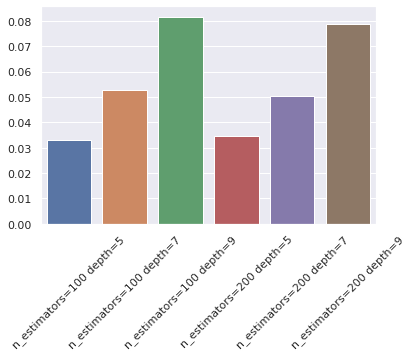

In [80]:
xs = [
    'n_estimators=100 depth=5',
    'n_estimators=100 depth=7',
    'n_estimators=100 depth=9',
    'n_estimators=200 depth=5',
    'n_estimators=200 depth=7',
    'n_estimators=200 depth=9',
]
sns.barplot(x=xs, y=f1s)

plt.xticks(rotation=45)

### evaluate best model on test dataset

In [33]:
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=9,
    n_jobs=10,
    verbose=0,
    random_state=SEED
).fit(train_umap, train_y)

preds = clf.predict(test_umap)
tp_rf, tr_rf, tf_rf, ta_rf = calculate_metrics(preds, test_y)

print(f"test prec: {tp_rf}, recall:{tr_rf}, f1:{tf_rf} and acc:{ta_rf}")

test prec: 0.5697074010327022, recall:0.0418537017133464, f1:0.0779786795453207 and acc:0.6155451866404715


## Logistic regression with dimension reduction

### train model and find best parameters

In [34]:
%%time

from sklearn.linear_model import LogisticRegression




train_acc = []
train_f1 = [] 
train_prec = []
train_recall = []

valid_acc = []
valid_f1 = [] 
valid_prec = []
valid_recall = []

for max_iter in [5, 10, 25, 50, 100, 150, 200]:
    clf = LogisticRegression(
        penalty='l2',
        max_iter=max_iter,
        verbose=0,
        n_jobs=10
    ).fit(train_umap, train_y)
    
    preds = clf.predict(train_umap)
    tp, tr, tf, ta = calculate_metrics(preds, train_y)
    train_acc.append(ta)
    train_prec.append(tp)
    train_recall.append(tr)
    train_f1.append(tf)
    
    preds = clf.predict(valid_umap)
    tp, tr, tf, ta = calculate_metrics(preds, valid_y)
    valid_acc.append(ta)
    valid_prec.append(tp)
    valid_recall.append(tr)
    valid_f1.append(tf)
    
    


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

CPU times: user 8.48 s, sys: 20.4 s, total: 28.8 s
Wall time: 58.6 s


### visualize metrics

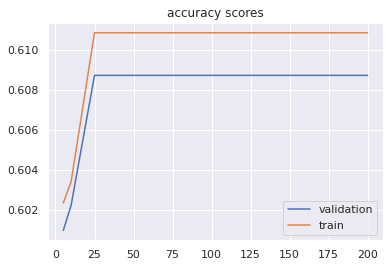

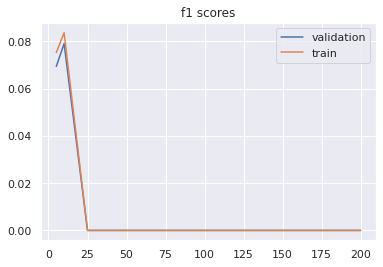

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

iters = [5, 10, 25, 50, 100, 150, 200]

sns.lineplot(x=iters, y=valid_acc)
sns.lineplot(x=iters, y=train_acc)
plt.legend(['validation', 'train'])
plt.title("accuracy scores")
plt.show()

sns.lineplot(x=iters, y=valid_f1)
sns.lineplot(x=iters, y=train_f1)
plt.legend(['validation', 'train'])
plt.title("f1 scores")
plt.show()


#### pick best model and report test metrics

In [36]:
clf = LogisticRegression(
    penalty='l2',
    max_iter=5,
    verbose=1,
    n_jobs=10
).fit(train_tfidf, train_y)

preds = clf.predict(test_tfidf)
tp, tr, tf, ta = calculate_metrics(preds, test_y)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   11.5s finished


In [37]:
import tabulate

print(tabulate.tabulate([['test_precision', tp], ['test_recall', tr], ['test_f1', tf], ['test_accuracy', ta]], tablefmt='grid'))

+----------------+----------+
| test_precision | 0.594483 |
+----------------+----------+
| test_recall    | 0.237643 |
+----------------+----------+
| test_f1        | 0.339551 |
+----------------+----------+
| test_accuracy  | 0.640909 |
+----------------+----------+


## BERT model

### loading BERT model

In [6]:
from transformers import BertTokenizer, BertModel, BertConfig
import torch

device = 'cuda:1'

config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased", config=config)
bert_model = bert_model.to(device)
bert_model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [7]:
import torch 
from tqdm import tqdm

def get_results_batched(model, tokenizer, str_l, bs=256, average_k_layers=1):
    i = 0
    result = []
    pbar = tqdm(total=len(str_l))
    while i < len(str_l):
        batch = list(str_l[i:i+bs])
        with torch.no_grad():
            tokens = tokenizer(batch, return_tensors='pt', padding=True, truncation=True).to(device)
            res_full = model(**tokens, output_hidden_states=True).hidden_states
            layers = []

            for k in range(-average_k_layers,0):
                pooled_val = res_full[k].detach().cpu()
                # taking cls token embeddings
                layers.append(pooled_val[:,0,:])

            stacked_layers = torch.stack(layers, dim=1)
            #print(stacked_layers.shape)

            average_embs = torch.mean(stacked_layers, dim=1)
            #print(average_embs.shape)

            result.append(average_embs)
            i = i + bs
            pbar.update(bs)
    return torch.concat(result, dim=0)



### unsupervised dimension projection for BERT

#### getting test embeddings

In [8]:
test_x, test_y = zip(*test_ds)
bio_embs = get_results_batched(bert_model, bert_tokenizer, test_x, bs=256, average_k_layers=3)

203776it [02:43, 1247.64it/s]                            


#### pole embeddings

In [13]:
political_dimension = [
    ['republican', 'trump supporter', 'conservative'],
    ['democrat', 'biden', 'harris']
]

pole1 = get_results_batched(
    bert_model,
    bert_tokenizer,
    [','.join(political_dimension[0])],
    bs=256,
    average_k_layers=3
)

pole2 = get_results_batched(
    bert_model,
    bert_tokenizer,
    [','.join(political_dimension[1])],
    bs=256,
    average_k_layers=3
)

256it [00:00, 27664.49it/s]          
256it [00:00, 30454.71it/s]          


#### normalize embeddings

In [14]:
from numpy import linalg as LA
import numpy as np


def normalize(wv):
    # normalize vectors
    norms = np.apply_along_axis(LA.norm, 1, wv)
    wv = wv / (norms[:, np.newaxis]+1e-6)
    return wv


pole1_norm = normalize(pole1.numpy())[0]
pole2_norm = normalize(pole2.numpy())[0]
embs_norm = normalize(bio_embs.numpy())



#### projection to the dimension

In [15]:
def ripa(w, b):
    return w.dot(b)/LA.norm(b)

diff = pole2_norm - pole1_norm
scores = []
for e in embs_norm:
    scores.append(ripa(e, diff))
    
scores = [0.0 if x < 0 else 1.0 for x in scores]

In [16]:
tp_bert, tr_bert, tf_bert, ta_bert = calculate_metrics(scores, test_y)
tp_bert, tr_bert, tf_bert, ta_bert

(0.38633149777903475,
 0.8809002971486375,
 0.5371069958213189,
 0.41021611001964636)

### KNN classifier

#### load training, validation and test embeddings

In [9]:
train_x, train_y = zip(*train_ds)
train_bio_embs = get_results_batched(bert_model, bert_tokenizer, train_x, bs=256, average_k_layers=3)

733184it [09:38, 1268.07it/s]                            


In [10]:
valid_x, valid_y = zip(*valid_ds)
valid_bio_embs = get_results_batched(bert_model, bert_tokenizer, valid_x, bs=256, average_k_layers=3)

81664it [01:02, 1300.07it/s]                           


In [11]:
test_x, test_y = zip(*test_ds)
test_bio_embs = get_results_batched(bert_model, bert_tokenizer, test_x, bs=256, average_k_layers=3)

203776it [02:40, 1272.79it/s]                            


In [15]:
train_bio_embs = train_bio_embs.numpy()
valid_bio_embs = valid_bio_embs.numpy()
test_bio_embs = test_bio_embs.numpy()

#### classify samples

In [21]:
%%time 

from sklearn.neighbors import KNeighborsClassifier

train_acc = []
train_f1 = [] 
train_prec = []
train_recall = []

valid_acc = []
valid_f1 = [] 
valid_prec = []
valid_recall = []

for k in [3, 5, 10, 15, 20]:
    print(f"training with k={k}")
    clf = KNeighborsClassifier(
        n_jobs=10,
        metric='cosine'
    ).fit(train_bio_embs[:10000], train_y[:10000])
    
    preds = clf.predict(train_bio_embs)
    tp, tr, tf, ta = calculate_metrics(preds, train_y)
    train_acc.append(ta)
    train_prec.append(tp)
    train_recall.append(tr)
    train_f1.append(tf)
    
    preds = clf.predict(valid_bio_embs)
    tp, tr, tf, ta = calculate_metrics(preds, valid_y)
    valid_acc.append(ta)
    valid_prec.append(tp)
    valid_recall.append(tr)
    valid_f1.append(tf)
    
    

training with k=3
training with k=5
training with k=10
training with k=15
training with k=20
CPU times: user 1h 25min 19s, sys: 56min 33s, total: 2h 21min 52s
Wall time: 21min 46s


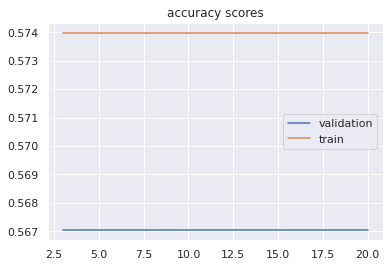

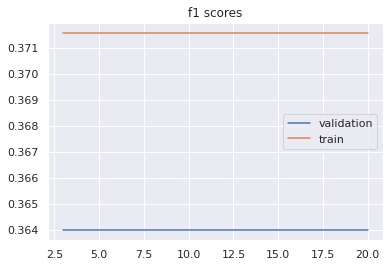

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

iters = [3, 5, 10, 15, 20]

sns.lineplot(x=iters, y=valid_acc)
sns.lineplot(x=iters, y=train_acc)
plt.legend(['validation', 'train'])
plt.title("accuracy scores")
plt.show()

sns.lineplot(x=iters, y=valid_f1)
sns.lineplot(x=iters, y=train_f1)
plt.legend(['validation', 'train'])
plt.title("f1 scores")
plt.show()


#### pick best model and report test metrics

In [26]:
# clf = LogisticRegression(
#     penalty='l2',
#     max_iter=25,
#     verbose=1,
#     n_jobs=10
# ).fit(train_tfidf, train_y)

preds = clf.predict(test_bio_embs)
tp_knn, tr_knn, tf_knn, ta_knn = calculate_metrics(preds, test_y)

In [27]:
import tabulate

print(tabulate.tabulate([['test_precision', tp_knn], ['test_recall', tr_knn], ['test_f1', tf_knn], ['test_accuracy', ta_knn]], tablefmt='grid'))

+----------------+----------+
| test_precision | 0.433129 |
+----------------+----------+
| test_recall    | 0.321173 |
+----------------+----------+
| test_f1        | 0.368843 |
+----------------+----------+
| test_accuracy  | 0.573045 |
+----------------+----------+


### Logistic regression classifier

#### load training, validation and test embeddings

In [68]:
train_x, train_y = zip(*train_ds)
train_bio_embs = get_results_batched(bert_model, bert_tokenizer, train_x, bs=256, average_k_layers=3)

  4%|▍         | 8192/202356 [13:33<5:21:19, 10.07it/s]
733184it [23:45, 514.19it/s]                            


In [69]:
valid_x, valid_y = zip(*valid_ds)
valid_bio_embs = get_results_batched(bert_model, bert_tokenizer, valid_x, bs=256, average_k_layers=3)

81664it [01:22, 990.79it/s]                            


In [70]:
test_x, test_y = zip(*test_ds)
test_bio_embs = get_results_batched(bert_model, bert_tokenizer, test_x, bs=256, average_k_layers=3)

203776it [02:44, 1237.01it/s]                            


In [71]:
train_bio_embs = train_bio_embs.numpy()
valid_bio_embs = valid_bio_embs.numpy()
test_bio_embs = test_bio_embs.numpy()

#### classify samples

In [ ]:
%%time 

from sklearn.neighbors import KNeighborsClassifier

train_acc = []
train_f1 = [] 
train_prec = []
train_recall = []

valid_acc = []
valid_f1 = [] 
valid_prec = []
valid_recall = []

for max_iter in [5, 10, 25, 50, 100, 150, 200]:
    clf = LogisticRegression(
        penalty='l2',
        max_iter=max_iter,
        verbose=0,
        n_jobs=10
    ).fit(train_bio_embs, train_y)
    
    preds = clf.predict(train_bio_embs)
    tp, tr, tf, ta = calculate_metrics(preds, train_y)
    train_acc.append(ta)
    train_prec.append(tp)
    train_recall.append(tr)
    train_f1.append(tf)
    
    preds = clf.predict(valid_bio_embs)
    tp, tr, tf, ta = calculate_metrics(preds, valid_y)
    valid_acc.append(ta)
    valid_prec.append(tp)
    valid_recall.append(tr)
    valid_f1.append(tf)
    
    

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

iters = [3, 5, 10, 15, 20]

sns.lineplot(x=iters, y=valid_acc)
sns.lineplot(x=iters, y=train_acc)
plt.legend(['validation', 'train'])
plt.title("accuracy scores")
plt.show()

sns.lineplot(x=iters, y=valid_f1)
sns.lineplot(x=iters, y=train_f1)
plt.legend(['validation', 'train'])
plt.title("f1 scores")
plt.show()


#### pick best model and report test metrics

In [26]:
clf = LogisticRegression(
    penalty='l2',
    max_iter=25,
    verbose=1,
    n_jobs=10
).fit(train_tfidf, train_y)

preds = clf.predict(test_bio_embs)
tp_bertlr, tr_bertlr, tf_bertlr, ta_bertlr = calculate_metrics(preds, test_y)

In [27]:
import tabulate

print(tabulate.tabulate([['test_precision', tp_bertlr], ['test_recall', tr_bertlr], ['test_f1', tf_bertlr], ['test_accuracy', ta_bertlr]], tablefmt='grid'))

+----------------+----------+
| test_precision | 0.433129 |
+----------------+----------+
| test_recall    | 0.321173 |
+----------------+----------+
| test_f1        | 0.368843 |
+----------------+----------+
| test_accuracy  | 0.573045 |
+----------------+----------+


## sentence bert model

### loading model

In [37]:
%%time

from sentence_transformers import SentenceTransformer, models, util
from transformers import AutoTokenizer, AutoModel


device = 'cuda:1'
twitter_ft_sbert = SentenceTransformer('./models/miniLM-L6-twitter-out256/', device=device)
twitter_ft_sbert.eval()


/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(


CPU times: user 8.66 s, sys: 387 ms, total: 9.05 s
Wall time: 6.52 s


SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
  (3): Dense({'in_features': 384, 'out_features': 256, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

In [38]:
import torch 
from tqdm import tqdm

def get_sbertbased_results_batched(model, str_l, bs=256):
    i = 0
    result = []
    pbar = tqdm(total=len(str_l))
    while i < len(str_l):
        batch = list(str_l[i:i+bs])
        with torch.no_grad():
            embeddings = model.encode(batch, convert_to_tensor=True)
            result.append(embeddings.detach().cpu())
            
            i = i + bs
            pbar.update(bs)
    return torch.concat(result, dim=0)



### unsupervised dimension projection

#### loading test embeddings

In [ ]:
test_x, test_y = zip(*test_ds)
bio_embs = get_sbertbased_results_batched(twitter_ft_sbert, test_x, bs=256)

#### pole embeddings

In [19]:
political_dimension = [
    ['republican', 'trump supporter', 'conservative'],
    ['democrat', 'biden', 'harris']
]

pole1 = get_sbertbased_results_batched(
    twitter_ft_sbert,
    [','.join(political_dimension[0])],
    bs=256,
)

pole2 = get_sbertbased_results_batched(
    twitter_ft_sbert,
    [','.join(political_dimension[1])],
    bs=256,
)

256it [00:00, 37638.17it/s]          
256it [00:00, 43476.61it/s]          


#### normalize embeddings

In [20]:
from numpy import linalg as LA
import numpy as np


def normalize(wv):
    # normalize vectors
    norms = np.apply_along_axis(LA.norm, 1, wv)
    wv = wv / (norms[:, np.newaxis]+1e-6)
    return wv


pole1_norm = normalize(pole1.numpy())[0]
pole2_norm = normalize(pole2.numpy())[0]
embs_norm = normalize(bio_embs.numpy())



#### projection to the dimension

In [21]:
def ripa(w, b):
    return w.dot(b)/LA.norm(b)

diff = pole2_norm - pole1_norm
scores = []
for e in embs_norm:
    scores.append(ripa(e, diff))
    
scores = [0.0 if x < 0 else 1.0 for x in scores]

In [22]:
ripa(
    get_sbertbased_results_batched(
        twitter_ft_sbert,
        ['maga'],
        bs=256,
    ).numpy()[0],
    diff
)

256it [00:00, 35455.75it/s]          


-0.47110555

In [23]:
tp_ftsbert, tr_ftsbert, tf_ftsbert, ta_ftsbert = calculate_metrics(scores, test_y)
tp_ftsbert, tr_ftsbert, tf_ftsbert, ta_ftsbert

(0.4617706631819667,
 0.44682303850287663,
 0.45417389627915944,
 0.5828290766208252)

/projects/academic/kjoseph/navid/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1801     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.08049D+05    |proj g|=  8.12570D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 1801     25     32      1     0     0   1.939D+01   4.605D+05
  F =   460496.07435839187     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


### unsupervised dimension projection on PIs

#### loading test embeddings

In [55]:
test_x, test_y = zip(*test_ds)
test_x = [generate_personal_identifiers(x) for x in test_x]
test_x[:5]


[['just a 22 year old living one hell of a life'],
 ['mom',
  'nurse',
  'animal lover',
  'hockey lover',
  'david beckham lover',
  'adore my true friends',
  'limits are set with family'],
 ['catholic', 'business management', 'txst 21'],
 ["hulk hogan's fourth cousin", 'twice removed', 'he', 'him', 'his'],
 ['mom of 3',
  'occupational therapist',
  'rodan+fields business owner',
  'user',
  'love all things outlander',
  'nodcc',
  'clt-lana']]

In [58]:
test_ds_pi = zip(test_x, test_y)
test_ds_pi = [(x[0], x[1]) for x in test_ds_pi if len(x[0])>0]
test_x_pi, test_y_pi = zip(*test_ds_pi)

test_x_pi = [', '.join(x) for x in test_x_pi]
bio_embs = get_sbertbased_results_batched(twitter_ft_sbert, test_x_pi, bs=256)


 40%|███▉      | 80128/202356 [00:41<01:07, 1799.25it/s]


 82%|████████▏ | 165376/202356 [01:21<00:18, 1991.87it/s]


100%|█████████▉| 202240/202356 [01:39<00:00, 2278.47it/s]
202496it [02:06, 1596.58it/s]                            


In [59]:
test_x_pi[:5]

['just a 22 year old living one hell of a life',
 'mom, nurse, animal lover, hockey lover, david beckham lover, adore my true friends, limits are set with family',
 'catholic, business management, txst 21',
 "hulk hogan's fourth cousin, twice removed, he, him, his",
 'mom of 3, occupational therapist, rodan+fields business owner, user, love all things outlander, nodcc, clt-lana']

#### pole embeddings

In [60]:
political_dimension = [
    ['republican', 'trump supporter', 'conservative'],
    ['democrat', 'biden', 'harris']
]

pole1 = get_sbertbased_results_batched(
    twitter_ft_sbert,
    [','.join(political_dimension[0])],
    bs=256,
)

pole2 = get_sbertbased_results_batched(
    twitter_ft_sbert,
    [','.join(political_dimension[1])],
    bs=256,
)


256it [00:00, 27136.62it/s]          

256it [00:00, 34315.81it/s]          


#### normalize embeddings

In [63]:
from numpy import linalg as LA
import numpy as np


def normalize(wv):
    # normalize vectors
    norms = np.apply_along_axis(LA.norm, 1, wv)
    wv = wv / (norms[:, np.newaxis]+1e-6)
    return wv


pole1_norm = normalize(pole1.numpy())[0]
pole2_norm = normalize(pole2.numpy())[0]
embs_norm = normalize(bio_embs.numpy())



#### projection to the dimension

In [64]:
def ripa(w, b):
    return w.dot(b)/LA.norm(b)

diff = pole2_norm - pole1_norm
scores = []
for e in embs_norm:
    scores.append(ripa(e, diff))
    
scores = [0.0 if x < 0 else 1.0 for x in scores]

In [65]:
ripa(
    get_sbertbased_results_batched(
        twitter_ft_sbert,
        ['maga'],
        bs=256,
    ).numpy()[0],
    diff
)


256it [00:00, 27608.30it/s]          


-0.47110555

In [67]:
tp_ftsbert_pi, tr_ftsbert_pi, tf_ftsbert_pi, ta_ftsbert_pi = calculate_metrics(scores, test_y_pi)
tp_ftsbert_pi, tr_ftsbert_pi, tf_ftsbert_pi, ta_ftsbert_pi

(0.46539502164502167,
 0.4376343675660548,
 0.45108798982488574,
 0.5862489869339185)

# Comparing all models

Text(0, 0.5, 'F-1 score')

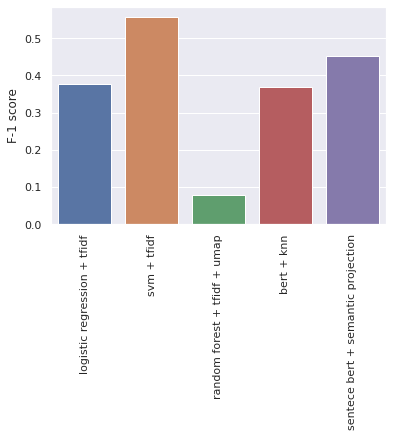

In [83]:
sns.barplot(
    x = [
        'logistic regression + tfidf',
        'svm + tfidf',
        'random forest + tfidf + umap',
        'bert + knn',
        'sentece bert + semantic projection'
    ],
    y = [
        0.375608,
        0.556818,
        0.077978,
        0.3688,
        0.451087,
    ]
)

plt.xticks(rotation=90)
plt.ylabel('F-1 score')